In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import umap
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm import tqdm

X_raw = np.load('mp_all_emb_penultimate_512.npy') ## (9800, 512)
azim_labels = np.squeeze(np.load('../mp_all_azim.npy')) ## only 0 or 180
elev_labels_raw = np.squeeze(np.load('../mp_all_elev.npy')) ## 
noiseHigh = np.squeeze(np.load('../mp_all_noise_high.npy')) # (9800,)
noiseLow = np.squeeze(np.load('../mp_all_noise_low.npy'))
mask = np.isin(azim_labels, [0]) & np.isin(noiseHigh, [20000]) # & np.isin(noiseLow, [20])
indices = np.where(mask)[0]
X = X_raw[indices]
c = elev_labels_raw[indices] # without considering elevation
c = (c - c.min()) / (c.max() - c.min()) 

N_class = len(np.unique(c))

In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", message=".*Graph is not fully connected.*")
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden to 1.*")

n_neighbors = 20
min_dist = 1
umap_model = umap.UMAP(n_neighbors = n_neighbors, min_dist=min_dist, n_components=2, random_state=0) 
umap_results = umap_model.fit_transform(X) ## (262200, 2)

umap_df = pd.DataFrame({
    "umap1": umap_results[:, 0],
    "umap2": umap_results[:, 1],
    "angle": c,                       # values in [0,1], here 7 discrete levels
    "noiseHigh": noiseHigh[indices],
    "noiseLow": noiseLow[indices],
})

temp_emb shape(350, 2)
temp_emb shape(350, 2)
temp_emb shape(350, 2)
temp_emb shape(350, 2)


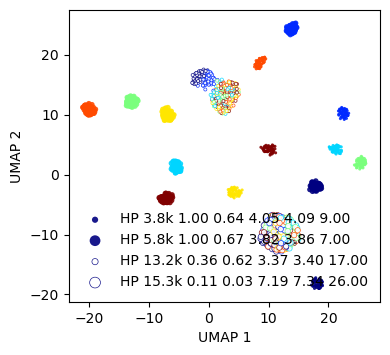

In [4]:
from compute_nmi_r2 import compute_nmi_r2

fig, ax = plt.subplots(figsize=(4, 4))

unique_angles = np.unique(umap_df["angle"].values)  # should be 7 values
# make bin edges halfway between unique values so they're non-overlapping
step = unique_angles[1] - unique_angles[0]
bounds = np.concatenate((
    [unique_angles[0] - step / 2],
    (unique_angles[:-1] + unique_angles[1:]) / 2,
    [unique_angles[-1] + step / 2],
))

# discrete colormap with 7 entries
# cmap = plt.cm.get_cmap('jet', len(unique_angles))
cmap = plt.colormaps.get_cmap('jet')
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# color for every point based on its discrete angle
colors = cmap(norm(umap_df["angle"].values))

mask = (umap_df["noiseLow"] == 3800)
nmi, r2, pr, prC, Dexp = compute_nmi_r2(X, umap_df, mask, N_class)
label_text = f"HP 3.8k {nmi:.2f} {r2:.2f} {pr:.2f} {prC:.2f} {Dexp:.2f}"
ax.scatter(
    umap_df.loc[mask, "umap1"],
    umap_df.loc[mask, "umap2"],
    s=5,
    c=colors[mask],
    alpha=0.9,
    linewidths=0,
    marker='o',
    label=label_text,
)

mask = (umap_df["noiseLow"] == 5800)
nmi, r2, pr, prC, Dexp = compute_nmi_r2(X, umap_df, mask, N_class)
label_text = f"HP 5.8k {nmi:.2f} {r2:.2f} {pr:.2f} {prC:.2f} {Dexp:.2f}"
ax.scatter(
    umap_df.loc[mask, "umap1"],
    umap_df.loc[mask, "umap2"],
    s=15,
    c=colors[mask],
    alpha=0.9,
    linewidths=0,
    marker='o',
    label=label_text,
)

mask = (umap_df["noiseLow"] == 13200)
nmi, r2, pr, prC, Dexp = compute_nmi_r2(X, umap_df, mask, N_class)
label_text = f"HP 13.2k {nmi:.2f} {r2:.2f} {pr:.2f} {prC:.2f} {Dexp:.2f}"
ax.scatter(
    umap_df.loc[mask, "umap1"],
    umap_df.loc[mask, "umap2"],
    s=5,
    facecolors='white',
    edgecolors=colors[mask],
    alpha=0.9,
    linewidths=0.5,
    marker='o',
    label=label_text,
)

mask = (umap_df["noiseLow"] == 15300)
nmi, r2, pr, prC, Dexp = compute_nmi_r2(X, umap_df, mask, N_class)
label_text = f"HP 15.3k {nmi:.2f} {r2:.2f} {pr:.2f} {prC:.2f} {Dexp:.2f}"
ax.scatter(
    umap_df.loc[mask, "umap1"],
    umap_df.loc[mask, "umap2"],
    s=15,
    facecolors='white',
    edgecolors=colors[mask],
    alpha=0.9,
    linewidths=0.5,
    marker='o',
    label=label_text,
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_aspect('equal', adjustable='box')
ax.legend(markerscale=2, frameon=False)
plt.tight_layout()
# plt.savefig('A03_high20k_n_neighbors'+str(n_neighbors)+'_min_dist'+str(min_dist)+'_legend_off.pdf', dpi=300, bbox_inches='tight')
plt.show()